# Testing Notebook

**Note:** This Jupyter notebook is for testing and playing around with the data. It is not a final product. Let me know if you have problems with it in Github Issues.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

In [47]:
multichoice = pd.read_csv('cleaned_multichoice.csv')
# print(multichoice.head())

## Correlation matrix
The first visualization, the correlation matrix, is used to find columns that relate to each other or *correlate*. This can help brainstorm ideas for future visualizations. My code below randomly chooses 10 columns from the cleaned data and analyzes the correlation.


You only need to look at the data under and to the left of the red squares as it is mirrored to the other side.

In [ ]:
selected_columns = np.random.choice(
    multichoice.columns, size=20, replace=False)
random_multichoice = multichoice[selected_columns]
corr_matrix = random_multichoice.corr()

# Plotting the correlation matrix
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()


c:\Users\Parthiv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Parthiv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Parthiv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Parthiv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

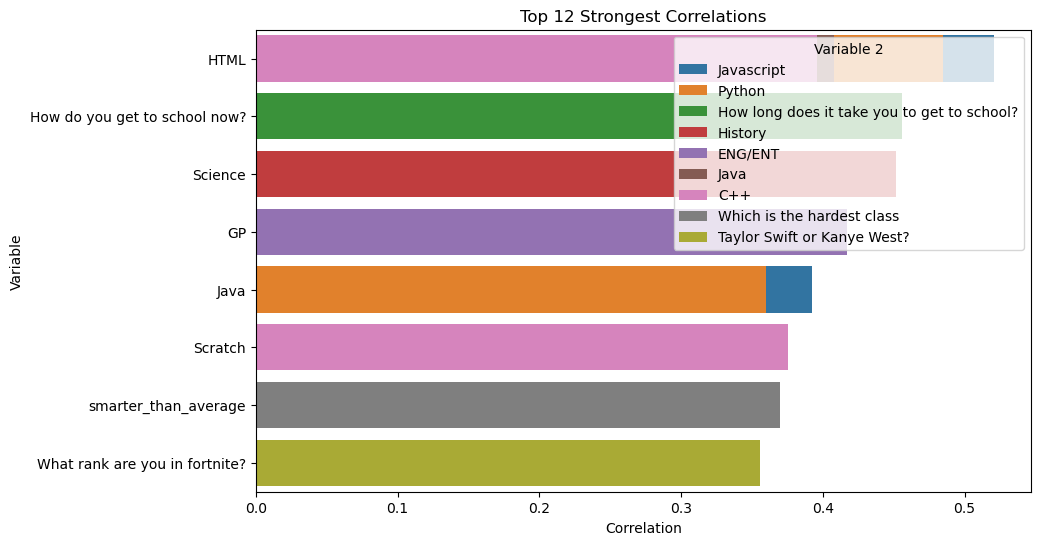

In [53]:
strongest_corr_matrix = multichoice.corr()

# Get the absolute values of the correlations
abs_corr = strongest_corr_matrix.abs()

# Create a mask to remove the upper triangle and the diagonal
mask = np.triu(np.ones_like(abs_corr, dtype=bool))

# Apply the mask
masked_corr = abs_corr.mask(mask)

# Get the top 12 correlations, dropna to remove NaNs
top_corr = masked_corr.unstack().dropna().sort_values(ascending=False).head(12)

# Create a DataFrame with the top correlations
top_corr_df = pd.DataFrame(top_corr, columns=['Correlation'])

# Reset the index and rename the columns
top_corr_df = top_corr_df.reset_index().rename(
    columns={'level_0': 'Variable 1', 'level_1': 'Variable 2'})

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(data=top_corr_df, x='Correlation',
            y='Variable 1', hue='Variable 2', dodge=False)
plt.title('Top 12 Strongest Correlations')
plt.xlabel('Correlation')
plt.ylabel('Variable')
plt.show()